##**Week 1(Word Tokenizer with word vocab)**##

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer


# list of input sentences to work with
sentences = [
    "I love my dog",
    "i, love my cat",
    "You love my dog!",
    "Do you think my dog is amazing?"
]

# max num of words to keep when gen sequences, i.e most frequent 100 if words, if uniqued words fit on is more than 100
# when gen sequence , words not in text used to fit tokenizer or vocably,  
# rather than being ignored replace with "<OOV>" tag token which is 1 here
tokenizer = Tokenizer(num_words = 100, oov_token = "<OOV>")  

tokenizer.fit_on_texts(sentences)

# gen sequences(encodings) for each sentence base on word idx
# and words not in word index will be ignored
sequences = tokenizer.texts_to_sequences(sentences)  

word_index = tokenizer.word_index
print(word_index)
print("\n", sequences)

{'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}

 [[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]


In [11]:
# use tokenizer to gen sequences from new test data
test_data = [
    "I really love my dog",
    "my dog loves my manatee"
]

test_seq = tokenizer.texts_to_sequences(test_data)
print(test_seq)

[[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]


In [14]:
# using pad to set length of each sequence. 
# if more than max trim.
# if less than max pad will 0
# and if actual length leave as such
# ensures shape of text token is always same, for passing to model

from tensorflow.keras.preprocessing.sequence import pad_sequences


# if maxlen isn't set it's got from max sentence token in sequence passed
padded = pad_sequences(test_seq, maxlen=10, padding="post", truncating="post")

print(f"Padded Sequences: \n{padded}")

Padded Sequences: 
[[5 1 3 2 4 0 0 0 0 0]
 [2 4 1 2 1 0 0 0 0 0]]


**Sarcasm dataset Tokenization**

In [15]:
# Download the dataset which is a json
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2022-09-14 11:37:47--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2022-09-14 11:37:47 (180 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [32]:
import json

with open("./sarcasm.json", "r") as f:
  datastore = json.load(f)  # a list of dict housing needed stuff

print(datastore[0]) # non-sarcastic headline
print(datastore[20000])  # sarcastic headline



{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}
{'article_link': 'https://www.theonion.com/pediatricians-announce-2011-newborns-are-ugliest-babies-1819572977', 'headline': 'pediatricians announce 2011 newborns are ugliest babies in 30 years', 'is_sarcastic': 1}


In [34]:
sentences = []
labels = []
urls = []

for item in datastore:
  sentences.append(item["headline"])
  labels.append(item["is_sarcastic"])
  urls.append(item["article_link"])


# len(sentences)
# len(labels)
# len(urls)

In [39]:
# preprocess headlines
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# take num_words to be in our sequence gen to be all uniqued words fitted on
tokenizer = Tokenizer(oov_token = "<OOV>")

tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index

print(f"total number of words in word index: {len(word_index)}")

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding = "post", truncating="post")  # padding max len == length of longest sentence


idx = 2
print(f"\nsample headline: {sentences[idx]}")
print(f"\npadded sequence: {padded[idx]}")
print(f"\nshape of padded sequences: n.b: cols rep max len of sequences: {padded.shape}")

total number of words in word index: 29657

sample headline: mom starting to fear son's web series closest thing she will have to grandchild

padded sequence: [  145   838     2   907  1749  2093   582  4719   221   143    39    46
     2 10736     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]

shape of padded sequences: n.b: cols rep max len of sequences: (26709, 40)


##**Week 2(Word Embeddings)**##
* N.B: Helps in preserving word sematincs in N-dim Vector

In [3]:
import tensorflow_datasets as tfds

# loading the IMDB dataset 
imdb, info = tfds.load("imdb_reviews", with_info = True, as_supervised=True)

print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGIR6Y0/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGIR6Y0/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGIR6Y0/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervis

In [4]:
# check examples of training set and print contents
for example in imdb["train"].take(2):

  # contains both sentence and label tensor
  print(example)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on

In [5]:
# split data
import numpy as np

train_data, test_data = imdb["train"], imdb["test"]


training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s, l in train_data:
  training_sentences.append(s.numpy().decode("utf8"))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [71]:
# params
vocab_size = 10000
max_length = 120
embedding_dim = 16
trunc_types = "post"
oov_tok = "<OOV>"

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type, padding=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type, padding=trunc_type)

In [73]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(3, "relu"),
    tf.keras.layers.Dense(1, "sigmoid")
])


model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d_5   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_22 (Dense)            (None, 3)                 51        
                                                                 
 dense_23 (Dense)            (None, 1)                 4         
                                                                 
Total params: 160,055
Trainable params: 160,055
Non-trainable params: 0
_________________________________________________________________


In [74]:
# train model(input is the padded sequence)

EPOCHS = 10

history = model.fit(padded, training_labels_final, epochs = EPOCHS, validation_data = (testing_padded, testing_labels_final))


Epoch 1/10
782/782 [==============================] - 6s 7ms/step - loss: 0.5974 - accuracy: 0.6878 - val_loss: 0.4501 - val_accuracy: 0.8179
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 0.3559 - accuracy: 0.8592 - val_loss: 0.3731 - val_accuracy: 0.8356
Epoch 3/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2824 - accuracy: 0.8860 - val_loss: 0.3688 - val_accuracy: 0.8364
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.2451 - accuracy: 0.9035 - val_loss: 0.3802 - val_accuracy: 0.8350
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2185 - accuracy: 0.9184 - val_loss: 0.4067 - val_accuracy: 0.8282
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1973 - accuracy: 0.9286 - val_loss: 0.4205 - val_accuracy: 0.8292
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 0.1800 - accuracy: 0.9365 - val_loss: 0.4462 - val_accuracy: 0.8240
Epoch 

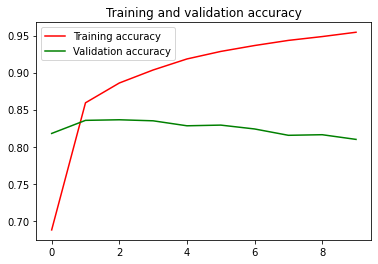

In [75]:
# viz results 
import matplotlib.pyplot as plt


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# accuracy

**Viz Word Embeddings**

In [32]:
# gets the embedding layer
embedding_layer = model.layers[0]

embedding_weights = embedding_layer.get_weights()[0]

# vocab_size, embedding_dim
print(embedding_weights.shape)

(10000, 16)


In [33]:
# vecs.tsv - contains the vector weights of each word in the vocabulary
# meta.tsv - contains the words in the vocabulary

import io

# gets the index-word dict, rather than word-index dict
reverse_word_index = tokenizer.index_word


# open writeable files
out_v = io.open("vects.tsv", "w", encoding = "utf-8")
out_m = io.open("meta.tsv", "w", encoding = "utf-8")


# init loop and start at 1 since 0 is for padding
for word_num in range(1, vocab_size):

  # gets the word mapped to this index
  word_name = reverse_word_index[word_num]

  # gets embedding weights associated awith this index or vocab
  word_embedding = embedding_weights[word_num]

  # wrote word name to meta file
  out_m.write(word_name + "\n")

  # write word embedding to vect file
  out_v.write("\t".join([str(x) for x in word_embedding]) + "\n")

out_v.close()
out_m.close()

In [37]:
# download files that can be visualized on https://projector.tensorflow.org/
try:
  from google.colab import files
except:
  pass

else:
  files.download("vects.tsv")
  files.download("meta.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Training Sarcasm clf**

In [1]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

--2022-09-14 18:05:56--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  32.1MB/s    in 0.2s    

2022-09-14 18:05:57 (32.1 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [72]:
# Number of examples to use for training
training_size = 20000

# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 32

# Output dimensions of the Embedding layer
embedding_dim = 16

In [73]:
# data splitting

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [74]:
# preprocess data
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [75]:
# testing out GlobalAveragePooling1D

import tensorflow as tf


gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

sample_array = np.array([[
    [10, 2], [1, 3], [1, 1]
]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')


# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}') # from (10 + 1+ 1)/ 3 and (2 + 3+ 1)/ 2

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [76]:
# Build Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(0.001), metrics = ["accuracy"])

EPOCHS = 30

# Train the model
history = model.fit(training_padded, training_labels, epochs=EPOCHS, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6629 - accuracy: 0.5870 - val_loss: 0.5916 - val_accuracy: 0.8035 - 3s/epoch - 4ms/step
Epoch 2/30
625/625 - 2s - loss: 0.5368 - accuracy: 0.7035 - val_loss: 0.4501 - val_accuracy: 0.8433 - 2s/epoch - 3ms/step
Epoch 3/30
625/625 - 2s - loss: 0.4670 - accuracy: 0.7390 - val_loss: 0.3985 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 2s - loss: 0.4358 - accuracy: 0.7551 - val_loss: 0.3722 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 5/30
625/625 - 2s - loss: 0.4145 - accuracy: 0.7648 - val_loss: 0.3636 - val_accuracy: 0.8533 - 2s/epoch - 3ms/step
Epoch 6/30
625/625 - 2s - loss: 0.3930 - accuracy: 0.7783 - val_loss: 0.3524 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 7/30
625/625 - 2s - loss: 0.3486 - accuracy: 0.8568 - val_loss: 0.3455 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 8/30
625/625 - 2s - loss: 0.3071 - accuracy: 0.8812 - val_loss: 0.3520 - val_accuracy: 0.8468 - 2s/epoch - 4ms/step
Epoch 9/30
625/625 - 2s 

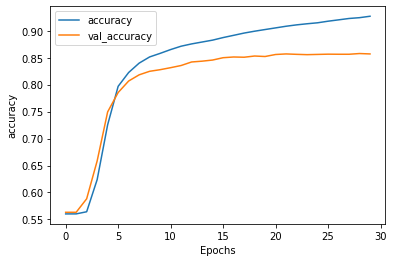

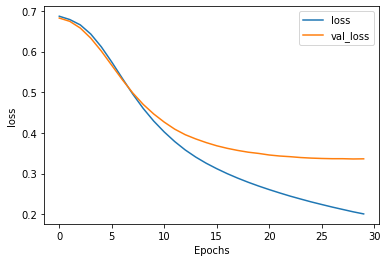

In [27]:
import matplotlib.pyplot as plt

# Plot helper
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**IMDB clf using subWord Tokenization**

In [1]:
import tensorflow_datasets as tfds

# Download the plain text default config
imdb_plaintext, info_plaintext = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Download the subword encoded pretokenized dataset
imdb_subwords, info_subwords = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWSP95G/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWSP95G/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWSP95G/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXE1X3L/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXE1X3L/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXE1X3L/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [2]:
print(f"imdb plain features: {info_plaintext.features}")
print(f"\nimdb sub_words tokenized: {info_subwords.features}")

imdb plain features: FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(), dtype=tf.string),
})

imdb sub_words tokenized: FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})


In [3]:
# Take 2 training examples and print the text feature
for example in imdb_plaintext['train'].take(2):
  print(example[0].numpy())

print("\n")
# Take 2 training examples and print its content
# which are sequences of word subwords tokens
for example in imdb_subwords['train'].take(2):
  print(example)

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was

In [4]:
# from the imdb subwords text features we can get the subwords tokenizer obj

# Gets the Encoder, to need to fit a tokenizer on any text
tokenizer_subwords = info_subwords.features["text"].encoder

# decodes the subwords_sequence and give same sentence as plain text config imdb
for example in imdb_subwords["train"].take(2):
  print(tokenizer_subwords.decode(example[0]))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was cons

**SubWords Encoding**

In [5]:
# Subword Encoding
train_data = imdb_plaintext["train"]

training_sentences = []

# appends sentences to training_sentences list
for s, _ in train_data:
  training_sentences.append(s.numpy().decode("utf8"))


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
oov_tok = '<OOV>'

# Initialize the Tokenizer class
tokenizer_plaintext = Tokenizer(num_words = 10000, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer_plaintext.fit_on_texts(training_sentences)

# Generate the training sequences
sequences = tokenizer_plaintext.texts_to_sequences(training_sentences)

# Decode the first sequence using the Tokenizer class
# notice that since our vocab is 10000, words not saved in vocab during fitting, even during encoding sequence of same text
# used in fitting, we get OOV since words not in top 10000 frequent words, hence not saved in vocab for gen sequence
# this is solved using subwords even when vocab is smaller
print(tokenizer_plaintext.sequences_to_texts(sequences[0:1]))

["this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor's like christopher <OOV> good name i could barely sit through it"]


In [6]:
# total num of words in word index dict but for vocab, uses just top 10,000 frequent words
len(tokenizer_plaintext.word_index)

88583

In [7]:
# Print the subwords
print(tokenizer_subwords.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [8]:
# solves oov problem by using part of the words to form whole words

# encodes plain textv using subword text encode
tokenized_string = tokenizer_subwords.encode(training_sentences[0])
print(f"{tokenized_string} \n")

# Decode the sequence
orig_string = tokenizer_subwords.decode(tokenized_string)
print(orig_string)

[62, 18, 41, 604, 927, 65, 3, 644, 7968, 21, 35, 5096, 36, 11, 43, 2948, 5240, 102, 50, 681, 7862, 1244, 3, 3266, 29, 122, 640, 2, 26, 14, 279, 438, 35, 79, 349, 384, 11, 1991, 3, 492, 79, 122, 188, 117, 33, 4047, 4531, 14, 65, 7968, 8, 1819, 3947, 3, 62, 27, 9, 41, 577, 5044, 2629, 2552, 7193, 7961, 3642, 3, 19, 107, 3903, 225, 85, 198, 72, 1, 1512, 738, 2347, 102, 6245, 8, 85, 308, 79, 6936, 7961, 23, 4981, 8044, 3, 6429, 7961, 1141, 1335, 1848, 4848, 55, 3601, 4217, 8050, 2, 5, 59, 3831, 1484, 8040, 7974, 174, 5773, 22, 5240, 102, 18, 247, 26, 4, 3903, 1612, 3902, 291, 11, 4, 27, 13, 18, 4092, 4008, 7961, 6, 119, 213, 2774, 3, 12, 258, 2306, 13, 91, 29, 171, 52, 229, 2, 1245, 5790, 995, 7968, 8, 52, 2948, 5240, 8039, 7968, 8, 74, 1249, 3, 12, 117, 2438, 1369, 192, 39, 7975] 

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not 

In [9]:
# Even performs better on text not previously seen

sample_string = "Hello there mate, I use tensorflow for deep learning model training and looking to gain mastery"

# Encode
tokenized_string_word_tokenizer = tokenizer_plaintext.texts_to_sequences([sample_string])
tokenized_string_subwords_tokenizer = tokenizer_subwords.encode(sample_string)

# Decode and print the result
original_string_word = tokenizer_plaintext.sequences_to_texts(tokenized_string_word_tokenizer)
original_string_subword = tokenizer_subwords.decode(tokenized_string_subwords_tokenizer)
print ('The original string using word tokenizer: {}'.format(original_string_word[0]))
print ('\nThe original string using subword tokenizer: {}'.format(original_string_subword))


# Show token to subword mapping:
for ts in tokenized_string_subwords_tokenizer:
  print ('{} ----> {}'.format(ts, tokenizer_subwords.decode([ts])))

The original string using word tokenizer: hello there mate i use <OOV> for deep learning model training and looking to gain <OOV>

The original string using subword tokenizer: Hello there mate, I use tensorflow for deep learning model training and looking to gain mastery
4025 ----> Hell
222 ----> o 
91 ----> there 
4719 ----> mate
2 ----> , 
12 ----> I 
415 ----> use 
943 ----> ten
2327 ----> sor
2934 ----> flow
7961 ---->  
23 ----> for 
2173 ----> deep 
5635 ----> learn
34 ----> ing 
2890 ----> model
7961 ---->  
7004 ----> training
7961 ---->  
5 ----> and 
357 ----> looking 
7 ----> to 
7659 ----> gain 
2652 ----> master
8050 ----> y


In [16]:
# triaining the already tokenized imdb subwords train data
BUFFER_SIZE = 12000
BATCH_SIZE = 64

# since data is already a tf.data.Dataset obj could use helpers for getting a padded_batch(creating batches and padding array to be of fix size as before)

# Get the train and test splits
train_data, test_data = imdb_subwords['train'], imdb_subwords['test'], 

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)


import tensorflow as tf

# Define dimensionality of the embedding
embedding_dim = 28

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer_subwords.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

num_epochs = 10

# Set the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Start training
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 28)          229180    
                                                                 
 global_average_pooling1d_2   (None, 28)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 6)                 174       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 229,361
Trainable params: 229,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
391/391 [==============================] - 4s 8ms/step - loss: 0.6786 - accuracy: 0.6153 - val_loss: 0.

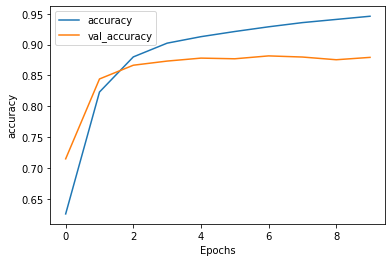

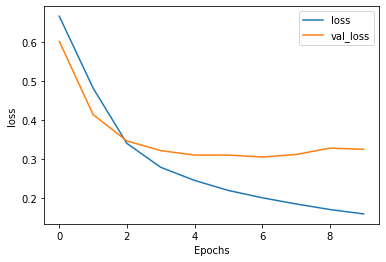

In [14]:
# viz results
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  epoch = num_epochs
  plt.plot(range(epoch), history.history[metric])
  plt.plot(range(epoch), history.history[f"val_{metric}"])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, f"val_{metric}"])
  plt.show()


plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
